In [357]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.cross_validation import train_test_split
import seaborn as sns
%matplotlib inline

from bs4 import BeautifulSoup

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

from dateutil import parser

plt.style.use('ggplot')


# Loading Glassdoor Data

In [358]:
# load Glassdoor Data
dta = pd.read_csv("main_df_Aug1.csv")
dta = dta.drop('Unnamed: 0', 1)
dta = dta.drop_duplicates()


In [359]:
# getting Distinct comapny with their average ratings from GlassDoor dataframe

q = "select name, avg(numberOfRatings) as numberOfRatings, avg(overallRating) as overallRating, \
avg(compensationAndBenefitsRating) as compensationAndBenefitsRating,\
avg(careerOpportunitiesRating) as careerOpportunitiesRating, avg(recommendToFriendRating) as recommendToFriendRating, \
avg(cultureAndValuesRating) as cultureAndValuesRating, avg(workLifeBalanceRating) as workLifeBalanceRating, \
avg(seniorLeadershipRating) as seniorLeadershipRating,  \
avg(ceonumratings) as ceonumratings, avg(ceopctapprove) as ceopctapprove from dta  \
group by name"

distinct_glassdoorDf = pysqldf(q)



In [360]:
# Getting median glassdoor ratings 

median_scoreDict={
    'overallRating': distinct_glassdoorDf['overallRating'].median(),
    'numberOfRatings':distinct_glassdoorDf['numberOfRatings'].median(),
    'compensationAndBenefitsRating':distinct_glassdoorDf['compensationAndBenefitsRating'].median(),
    'careerOpportunitiesRating':distinct_glassdoorDf['careerOpportunitiesRating'].median(),
    'recommendToFriendRating':distinct_glassdoorDf['recommendToFriendRating'].median(),
    'cultureAndValuesRating':distinct_glassdoorDf['cultureAndValuesRating'].median(),
    'workLifeBalanceRating':distinct_glassdoorDf['workLifeBalanceRating'].median(),
    'seniorLeadershipRating':distinct_glassdoorDf['seniorLeadershipRating'].median(),
    'ceonumratings':distinct_glassdoorDf['ceonumratings'].median(),
    'ceopctapprove':distinct_glassdoorDf['ceopctapprove'].median()
    
}


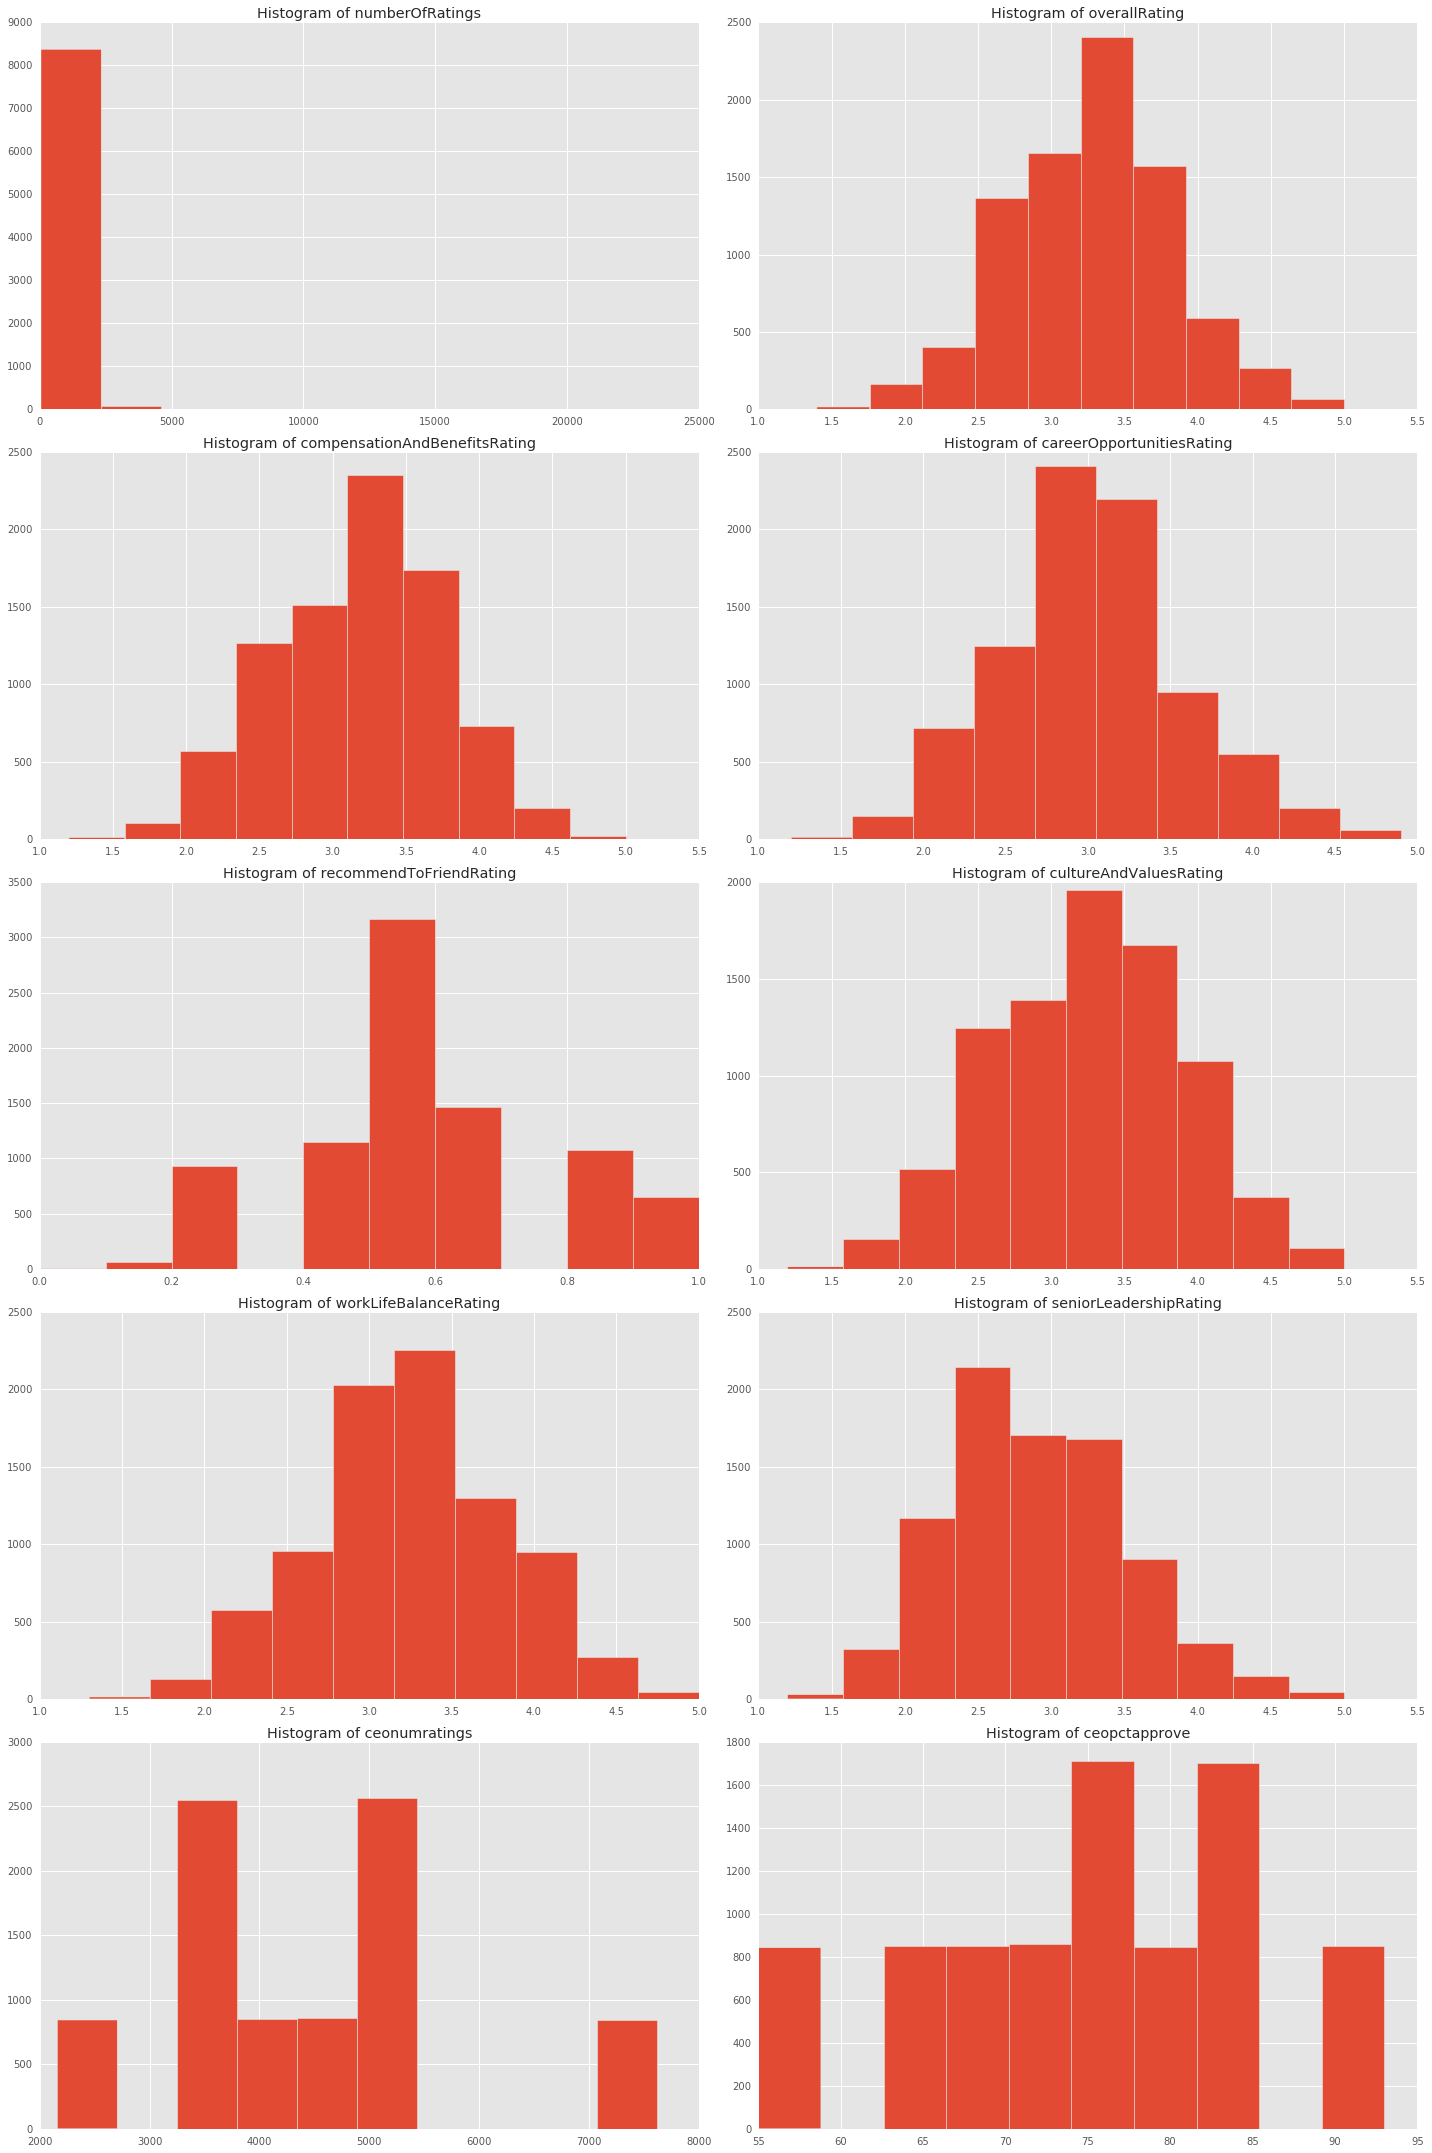

In [361]:
dist_cols = list(distinct_glassdoorDf.columns)

plt.figure(figsize=(20,30))

for i, name in enumerate(dist_cols[1:]):
    plt.subplot(5,2,i+1)
    plt.hist(distinct_glassdoorDf[name])
    plt.title('Histogram of ' + str(name))
    plt.tight_layout()

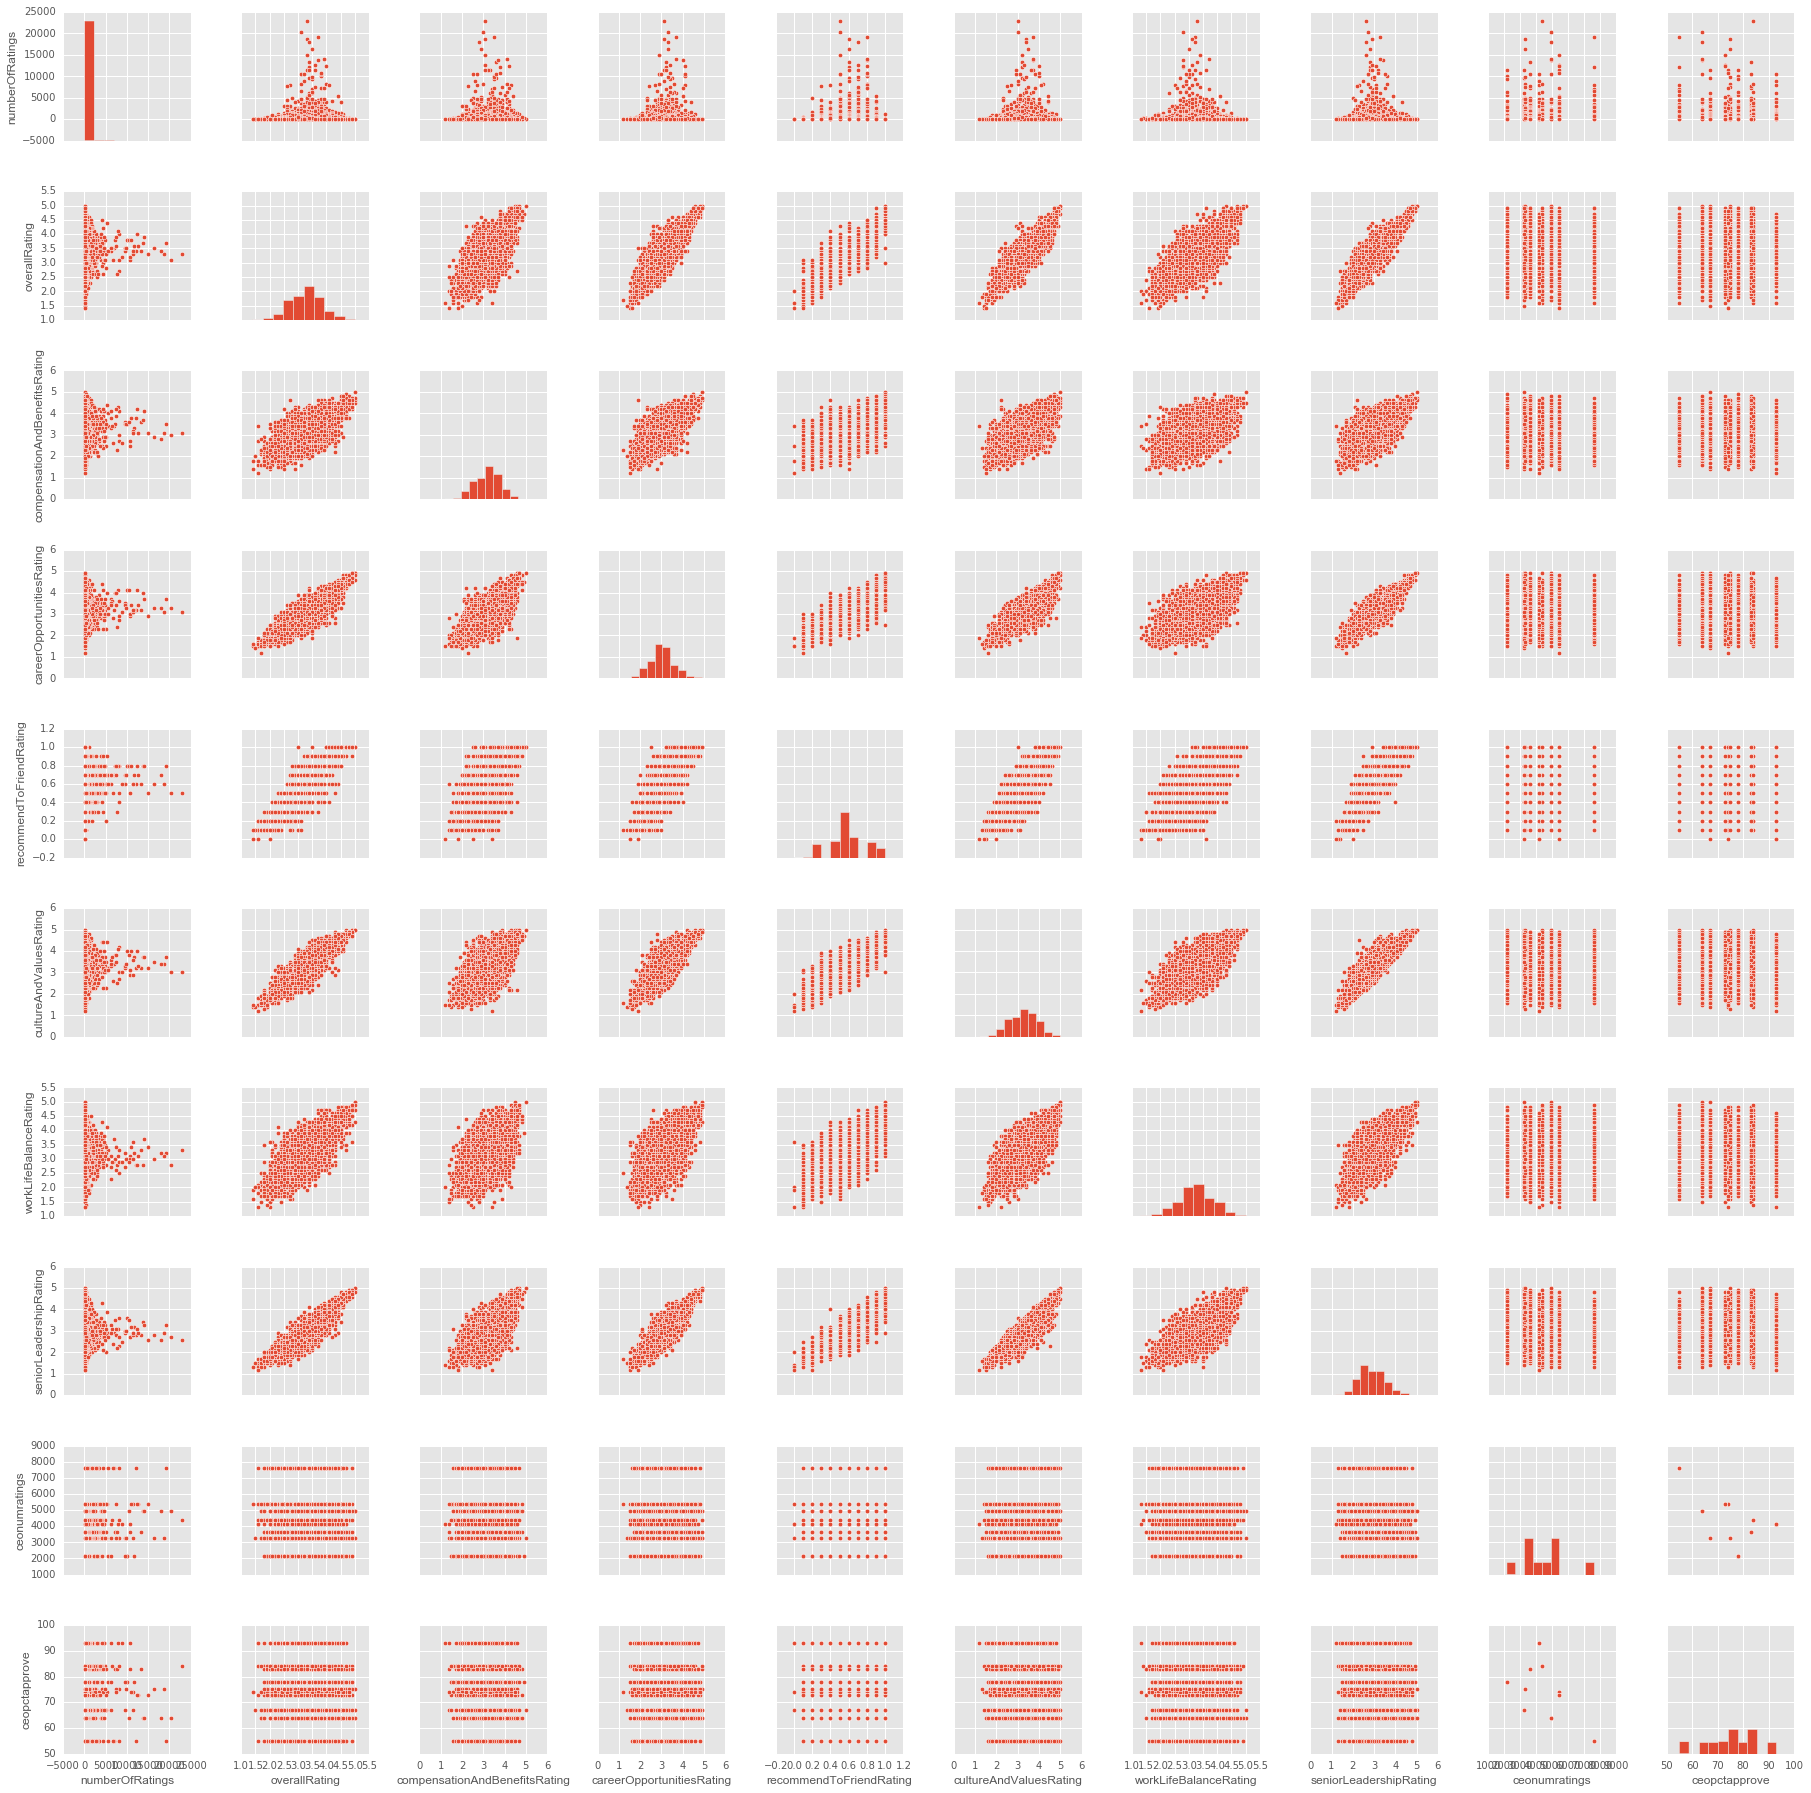

In [362]:
sns.pairplot(distinct_glassdoorDf)

# Load Crunchbase Data

In [363]:
cb_df = pd.read_csv("/Users/deepakgautam/octo-parakeet/Crunchbase/companies.csv")

In [364]:
cName_df = pd.DataFrame()
cbUSA_df = cb_df[cb_df['country_code']=='USA']

In [365]:
cbUSA_df.founded_at.dropna().min()

'1636-09-08'

*** Feature Engineering Final Table without Dummies ***
    

In [382]:
# Setting up final table to send to classification models
modelCB_df = cbUSA_df

# dropping irrelevent columns
modelCB_df = modelCB_df.drop('permalink', 1)
modelCB_df = modelCB_df.drop('homepage_url', 1)
modelCB_df = modelCB_df.drop('category_list', 1)
modelCB_df = modelCB_df.drop('country_code', 1)
modelCB_df = modelCB_df.drop('state_code', 1)
modelCB_df = modelCB_df.drop('region', 1)
modelCB_df = modelCB_df.drop('city', 1)

# cleaning total funding column
modelCB_df['funding_total_usd'] = pd.to_numeric(modelCB_df['funding_total_usd'],errors='coerce')


#changing columns to date time and creating new columns with date diff
modelCB_df['founded_at'] = pd.to_datetime(modelCB_df['founded_at'], format="%Y-%m-%d", errors='coerce')
modelCB_df['first_funding_at'] = pd.to_datetime(modelCB_df['first_funding_at'], format="%Y-%m-%d", errors='coerce')
modelCB_df['last_funding_at'] = pd.to_datetime(modelCB_df['last_funding_at'], format="%Y-%m-%d", errors='coerce')
modelCB_df['daysToFirstFunding'] = (modelCB_df['founded_at'] - modelCB_df['first_funding_at'])/ np.timedelta64(-1, 'D')
modelCB_df['daysBetweenFirstLastFunding'] = (modelCB_df['first_funding_at'] - modelCB_df['last_funding_at'])/ np.timedelta64(-1, 'D')

#print(modelCB_df.founded_at.dropna().min())
#print(len(modelCB_df[modelCB_df['founded_at']>='1990']))


# Apply median days  First Funding and Days Between to NaN values
firstFundingMedian = modelCB_df['daysToFirstFunding'].median()
lastFundingMedian = modelCB_df['daysBetweenFirstLastFunding'].median()
modelCB_df['daysToFirstFunding'] = modelCB_df['daysToFirstFunding'].fillna(firstFundingMedian)
modelCB_df['daysBetweenFirstLastFunding'] = modelCB_df['daysBetweenFirstLastFunding'].fillna(lastFundingMedian)




# Drop status, founded_at, first_funding_at, last_funding_at

modelCB_df = modelCB_df.drop('founded_at', 1)
modelCB_df = modelCB_df.drop('first_funding_at', 1)
modelCB_df = modelCB_df.drop('last_funding_at', 1)



In [383]:
# generating status id = 0 if company is closed , 1 otherwise 
# for multi layer analysis we will update this step
#modelCB_df['statusID'] = np.where(modelCB_df['status']=='closed', 0, 1)


In [384]:
# Getting VC Tiers data , cleaning it and merging with modelCB_df

In [385]:
vcTiers_df = pd.read_csv("/Users/deepakgautam/octo-parakeet/VC_tiers.csv")

In [386]:
q = "Select company_name, sum(tier_1) as tier_1, \
    sum(tier_2) as tier_2, sum(tier_3) as tier_3, \
    sum(tier_4) as tier_4, sum(tier_5) as tier_5 \
    from vcTiers_df Group By company_name"
vcTiers_dfUnique = pysqldf(q)


In [387]:
# Getting boolean values on whether a certain tier VC have invested or not 
def get_tierBoolean(val):
    if val >=1:
        return 1
    else:
        return 0

vcTiers_dfUnique['tier_1'] = vcTiers_dfUnique['tier_1'].apply(get_tierBoolean)
vcTiers_dfUnique['tier_2'] = vcTiers_dfUnique['tier_2'].apply(get_tierBoolean)
vcTiers_dfUnique['tier_3'] = vcTiers_dfUnique['tier_3'].apply(get_tierBoolean)
vcTiers_dfUnique['tier_4'] = vcTiers_dfUnique['tier_4'].apply(get_tierBoolean)
vcTiers_dfUnique['tier_5'] = vcTiers_dfUnique['tier_5'].apply(get_tierBoolean)




In [390]:
# Joining tables and updating null Values
q = "Select * from modelCB_df left join vcTiers_dfUnique on vcTiers_dfUnique.company_name = modelCB_df.name"

# Merged table is now set our new main CB table
cbUSA_dfWithVC = pysqldf(q)


cbUSA_dfWithVC['tier_1'] = cbUSA_dfWithVC['tier_1'].fillna(0)
cbUSA_dfWithVC['tier_2'] = cbUSA_dfWithVC['tier_2'].fillna(0)
cbUSA_dfWithVC['tier_3'] = cbUSA_dfWithVC['tier_3'].fillna(0) 
cbUSA_dfWithVC['tier_4'] = cbUSA_dfWithVC['tier_4'].fillna(0)
cbUSA_dfWithVC['tier_5'] = cbUSA_dfWithVC['tier_5'].fillna(0)

cbUSA_dfWithVC = cbUSA_dfWithVC.drop('company_name', 1)


(37601, 11) (37601, 6)


## Few Data Exploration 

In [391]:
modelCB_df.describe()

/Users/deepakgautam/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,funding_total_usd,funding_rounds,daysToFirstFunding,daysBetweenFirstLastFunding
count,3.142900e+04,37601.000000,37601.000000,37601.000000
mean,2.130179e+07,1.923513,1359.672642,425.877264
std,2.212258e+08,1.557549,3611.905639,762.267527
min,1.000000e+00,1.000000,-4852.000000,-0.000000
25%,NaN,1.000000,260.000000,-0.000000
50%,NaN,1.000000,575.000000,-0.000000
75%,NaN,2.000000,1174.000000,598.000000
max,3.007950e+10,19.000000,91028.000000,17287.000000


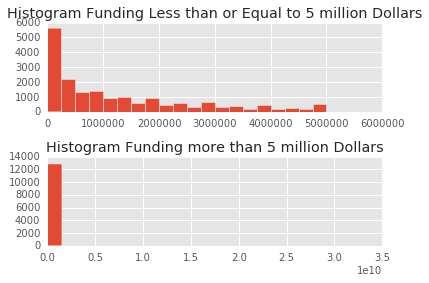

In [392]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(hspace=.5)

ax1.hist(list(modelCB_df['funding_total_usd']
              [modelCB_df['funding_total_usd']<=5e6].dropna()), bins =20)
ax1.set_title('Histogram Funding Less than or Equal to 5 million Dollars')

ax2.hist(list(modelCB_df['funding_total_usd']
              [modelCB_df['funding_total_usd']>5e6].dropna()), bins =20)
ax2.set_title('Histogram Funding more than 5 million Dollars')

plt.show()



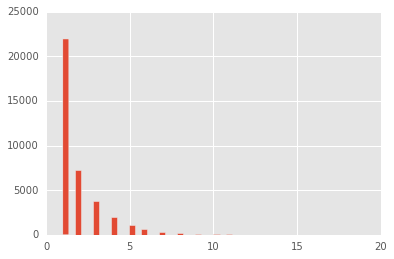

In [393]:
plt.hist(modelCB_df['funding_rounds'], bins=50);

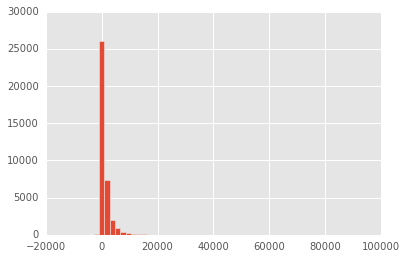

In [394]:
plt.hist(modelCB_df['daysToFirstFunding'], bins=50);

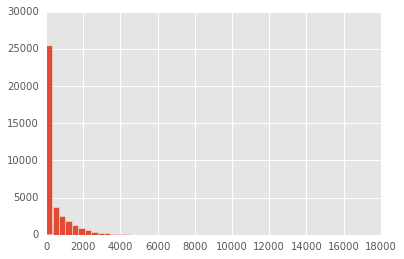

In [395]:
plt.hist(modelCB_df['daysBetweenFirstLastFunding'], bins=50);

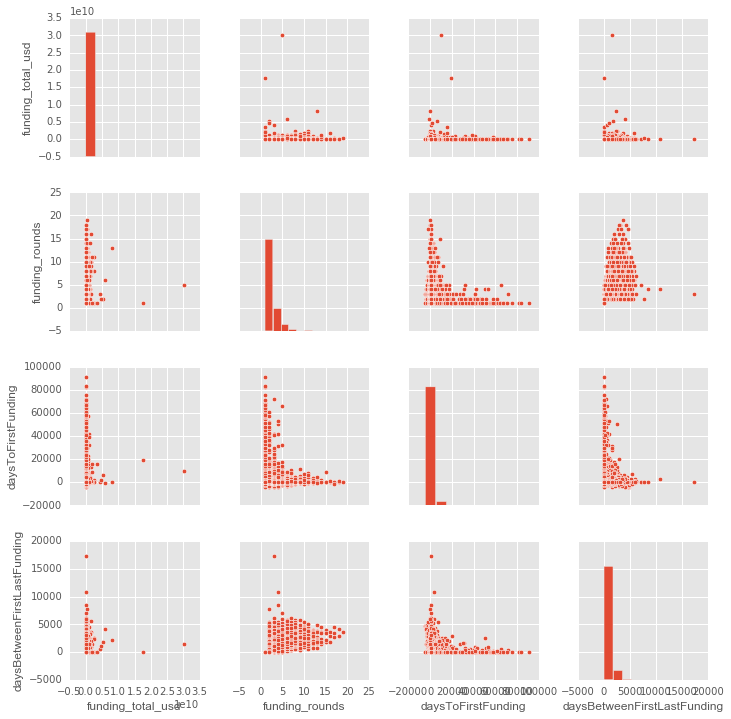

In [396]:
sns.pairplot(modelCB_df.dropna())

*** Creating Dummy Table ***

In [397]:
#Creating a temporary dataframe with just name and categoryList to get dummies of CategoryList
temp_cbUSA_df = cbUSA_df[['name','category_list']]

In [398]:
# creating complete category List. Single company has multiple category 
category_list = []
for item in temp_cbUSA_df['category_list'].str.split("|").values:
    if type(item) == list:
        category_list.extend(item)


In [399]:
# getting category with their counts
from collections import Counter
category_list = Counter(category_list)

In [400]:
# getting top 100 category to use as dummy variable
top_100_categories = category_list.most_common(100)
top_100_category_keys = dict(top_100_categories).keys()

In [401]:
def split_categories(row, top_categories):
    if type(row["category_list"]) == str:
        row_categories = row["category_list"].split("|")
        for category in row_categories:
            if category in top_categories:
                row[category] = 1
            
    return row

# Creating new dataframe with category dummy variables
cbUSA_dfWDummy = temp_cbUSA_df.apply(split_categories, axis=1, top_categories=top_100_category_keys)
cbUSA_dfWDummy = cbUSA_dfWDummy.drop('category_list', 1)

In [402]:
# Setting all NaN values in category dummy variables to 0 
for items in top_100_category_keys:
    cbUSA_dfWDummy[items] = cbUSA_dfWDummy[items].fillna(0)


** Creating Final Table Functions ready for classification (with Dummies) **

In [403]:
# Gives binary classification ready table
def getDataForBinaryClassification(cbTable,dummyTable,glassDoorTable,
                                   median_scoreDict,includeDummy,includeGlassdoor):
    cbTable['statusID'] = np.where(cbTable['status']=='closed', 0, 1)
    cbTable = cbTable.drop('status', 1)
    
    if includeDummy ==True:
        if includeGlassdoor == True:
            outputTable= pd.merge(cbTable, glassDoorTable, on='name', how='left')
            outputTable= pd.merge(outputTable, dummyTable, on='name', how='left')
        else:
            outputTable= pd.merge(cbTable, dummyTable, on='name', how='left')
    else:
        if includeGlassdoor == True:
            outputTable= pd.merge(cbTable, glassDoorTable, on='name', how='left')
        else:
            outputTable = cbTable
    
    
    if includeGlassdoor==True:
        for keys, values in median_scoreDict.items():
            outputTable[keys] = outputTable[keys].fillna(values) 
            

    outputTable = outputTable.drop('name', 1)
    
    return outputTable

In [404]:
# Gives multi level classification ready table 
def getDataForMultiClassification(cbTable,dummyTable,glassDoorTable,
                                  median_scoreDict,includeDummy,includeGlassdoor):
    status_values = {
        'closed' :0,
        'operating' : 1, 
        'acquired' : 2, 
        'ipo' : 3   
    }

    
    
    
    cbTable['statusID'] = cbTable['status'].map(status_values)
    cbTable = cbTable.drop('status', 1)
    
    if includeDummy ==True:
        if includeGlassdoor == True:
            outputTable= pd.merge(cbTable, glassDoorTable, on='name', how='left')
            outputTable= pd.merge(outputTable, dummyTable, on='name', how='left')
        else:
            outputTable= pd.merge(cbTable, dummyTable, on='name', how='left')
    else:
        if includeGlassdoor == True:
            outputTable= pd.merge(cbTable, glassDoorTable, on='name', how='left')
        else:
            outputTable = cbTable
    
    
    if includeGlassdoor==True:
        for keys, values in median_scoreDict.items():
            outputTable[keys] = outputTable[keys].fillna(values) 
            
        
    outputTable = outputTable.drop('name', 1)
    
    return outputTable
    

In [405]:
# #Another way to apply function to a column in a dataframe
# def get_status_values(val):
#     if val == "operating":
#         return 0
#     elif val == "ipo":
#         return 3
#     else:
#         return 1

# df['statusID'] = df['status'].apply(get_status_values)


# Classification Models

In [406]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
%matplotlib inline

In [407]:
## Here are the precision-recall curve and log-likelihood computation functions

import numpy as np
import matplotlib.pyplot as plt


def pr_curve(truthvec, scorevec, digit_prec=2):
    threshvec = np.unique(np.round(scorevec,digit_prec))
    numthresh = len(threshvec)
    tpvec = np.zeros(numthresh)
    fpvec = np.zeros(numthresh)
    fnvec = np.zeros(numthresh)

    for i in range(numthresh):
        thresh = threshvec[i]
        tpvec[i] = sum(truthvec[scorevec>=thresh])
        fpvec[i] = sum(1-truthvec[scorevec>=thresh])
        fnvec[i] = sum(truthvec[scorevec<thresh])
    recallvec = tpvec/(tpvec + fnvec)
    precisionvec = tpvec/(tpvec + fpvec)
    return (precisionvec,recallvec, threshvec)

def log_lik_binary(truthvec, probvec):
    return np.sum((np.log(probvec)*truthvec) + (np.log(1-probvec)*(1-truthvec)))

### Test Train Split

In [448]:
includeDummy = False
includeGlassdoor = False
reg_df = getDataForBinaryClassification(cbUSA_dfWithVC,cbUSA_dfWDummy,distinct_glassdoorDf,
                                   median_scoreDict,includeDummy,includeGlassdoor)
reg_df = reg_df.dropna()

X = reg_df.drop('statusID',1)
y = reg_df['statusID']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression

In [453]:
#Logistic Regression
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
pred_vals_lr = model_lr.predict_proba(X_test)

In [454]:
pred_vals_lr

array([[ 0.08142353,  0.91857647],
       [ 0.28421038,  0.71578962],
       [ 0.0451434 ,  0.9548566 ],
       ..., 
       [ 0.43351191,  0.56648809],
       [ 0.16651137,  0.83348863],
       [ 0.38162508,  0.61837492]])

In [455]:
X_train.columns

Index(['funding_total_usd', 'funding_rounds', 'daysToFirstFunding',
       'daysBetweenFirstLastFunding', 'tier_1', 'tier_2', 'tier_3', 'tier_4',
       'tier_5'],
      dtype='object')

In [456]:
model_lr.coef_

array([[  2.24460908e-08,   3.82183377e-06,   1.24888575e-03,
          6.24712334e-04,   8.97008271e-08,   4.54678774e-08,
          5.00750770e-08,   3.97638364e-08,   2.48560641e-08]])

In [459]:
precision , recall, threshVec = pr_curve(y_test,pred_vals_lr[:,1]);

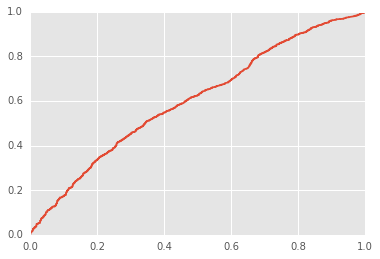

In [412]:
fpr, tpr, thresholds = roc_curve(y_test,pred_vals_lr[:,1])
plt.plot(fpr, tpr)




In [460]:
fig, ax = plt.subplots(1,2, figsize=(20,5), sharey=True)
fig.subplots_adjust(hspace=.5)
ax[0].plot(model[precision, recall, label='Logistic Regression')
ax[0].set_title('Precision-Recall Curve'])
ax[0].set_xlabel('Precision')
ax[0].set_ylabel('Recall')
ax[0].set_label('Logistic Regression')
ax[0].legend(title='')

ax[1].plot(fpr, tpr,label='Logistic Regression')
ax[1].set_title('ROC Curve'])
ax[1].legend(title='', loc='best')
  
plt.show()

SyntaxError: invalid syntax (<ipython-input-460-30df6e38b485>, line 3)

In [413]:
roc_auc_score(y_test,pred_vals_lr[:,1])

0.60192144686256233

# Doing Binary Classification for ALL models using ALL variables

In [414]:

includeDummy = True
includeGlassdoor = True
reg_df = getDataForBinaryClassification(cbUSA_dfWithVC,cbUSA_dfWDummy,distinct_glassdoorDf,
                                   median_scoreDict,includeDummy,includeGlassdoor)
reg_df = reg_df.dropna()

X = reg_df.drop('statusID',1)
y = reg_df['statusID']

random_state = 4444
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [415]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.learning_curve import learning_curve

from xgboost import XGBClassifier


In [416]:
random_state = 4444
all_models = [
    {
        'name': 'Logit',
        'model': LogisticRegression(random_state=random_state)
    },
    {
        'name': 'K-Nearest Neighbors',
        'model': KNeighborsClassifier(n_neighbors=4)
    },
    
    
    {
        'name': 'Gaussian Naive Bayes',
        'model': GaussianNB()
    },
#     {
#         'name': 'SVC',
#         'model': SVC(probability=True, random_state=random_state)
#     },
    
    {
        'name': 'Decision Tree',
        'model': DecisionTreeClassifier(random_state=random_state)
    },
    {
        'name': 'Random Forest',
        'model': RandomForestClassifier(random_state=random_state)
    }, 
    {
        'name': 'XG Boost',
        'model': XGBClassifier()
    }
    
]


In [419]:
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score

for model in all_models:
    cur_model = model['model']
    
    cur_model.fit(X_train, y_train)
    model['y_pred'] = model['model'].predict(X_test)
    model['accuracy'] = accuracy_score(y_test, model['y_pred'])
    model['precision'] = precision_score(y_test, model['y_pred'])
    model['recall'] = recall_score(y_test, model['y_pred'])
    model['f1'] = f1_score(y_test, model['y_pred'])
    model['y_proba'] = model['model'].predict_proba(X_test)[:, 1]
    
    pred_vals_lr = model['model'].predict_proba(X_test)
    
    model['roc'] = roc_curve(y_test, model['y_proba'])
    #m['pr_curve'] = precision_recall_curve(y_test, m['y_proba'])
    model['pr_curve'] = pr_curve(y_test,pred_vals_lr[:,1])
    
    model['auc'] = roc_auc_score(y_test, model['y_proba'])

In [420]:
for model in all_models:
    print(model['name'])
    print('    Accuracy: {}'.format(model['accuracy']))
    print('    Precision: {}'.format(model['precision']))
    print('    Recall: {}'.format(model['recall']))
    print('    F1: {}'.format(model['f1']))

Logit
    Accuracy: 0.9251105961659996
    Precision: 0.9251105961659996
    Recall: 1.0
    F1: 0.9610986485747114
K-Nearest Neighbors
    Accuracy: 0.8824520749947335
    Precision: 0.9260864732688674
    Recall: 0.948650802687009
    F1: 0.9372328458942631
Gaussian Naive Bayes
    Accuracy: 0.9251105961659996
    Precision: 0.9251105961659996
    Recall: 1.0
    F1: 0.9610986485747114
Decision Tree
    Accuracy: 0.8533810827891299
    Precision: 0.9277694177566848
    Recall: 0.9125583513605829
    F1: 0.9201010216967053
Random Forest
    Accuracy: 0.90362334105751
    Precision: 0.9269589754721077
    Recall: 0.972446772173517
    F1: 0.949158193032172
XG Boost
    Accuracy: 0.9251105961659996
    Precision: 0.9251105961659996
    Recall: 1.0
    F1: 0.9610986485747114


In [421]:
for i, model in enumerate(all_models):
    print('AUC score ' + model['name'] + ': '  + str(model['auc']))

AUC score Logit: 0.598638320128
AUC score K-Nearest Neighbors: 0.541568763849
AUC score Gaussian Naive Bayes: 0.576501994567
AUC score Decision Tree: 0.522041605435
AUC score Random Forest: 0.571326416442
AUC score XG Boost: 0.664397787376


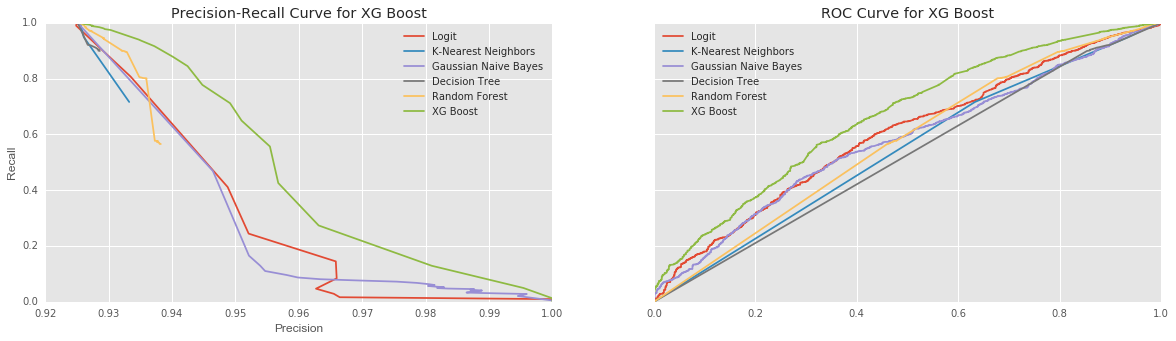

In [422]:
fig, ax = plt.subplots(1,2, figsize=(20,5), sharey=True)
fig.subplots_adjust(hspace=.5)
for i, model in enumerate(all_models):
    ax[0].plot(model['pr_curve'][0], model['pr_curve'][1], label=model['name'])
    ax[0].set_title('Precision-Recall Curve for ' + model['name'])
    ax[0].set_xlabel('Precision')
    ax[0].set_ylabel('Recall')
    ax[0].set_label(model['name'])
    ax[0].legend(title='')
    
    ax[1].plot(model['roc'][0], model['roc'][1],label=model['name'])
    ax[1].set_title('ROC Curve for ' + model['name'])
    ax[1].legend(title='', loc='best')
  
plt.show()

## XG Boost Binary Class Classification For Different Y's

In [437]:
from sklearn.preprocessing import label_binarize

includeDummy = True
includeGlassdoor = True
reg_df = getDataForMultiClassification(cbUSA_dfWithVC,cbUSA_dfWDummy,distinct_glassdoorDf,
                                   median_scoreDict,includeDummy,includeGlassdoor)

X = reg_df.drop('statusID',1)
y = reg_df['statusID']
orig_y = y 

# This command binarizes y columns into 4 differnt dummy variable columns
y = label_binarize(y, classes=[0, 1, 2,3])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [438]:
#

all_PossibleModels = [
    {
        'name': 'Closed vs Others'
        
    },
    {
        'name': 'Operating vs Others'
        
    },
    
    
    {
        'name': 'Acquired vs Others'
        
    },

    
    {
        'name': 'IPO vs Others'
    }
]


for i , model in enumerate(all_PossibleModels):
    model_xgb = XGBClassifier()
    model_xgb.fit(X_train, y_train[:,i])
    pred_prob_xgb = model_xgb.predict_proba(X_test)
    pr_curve(y_test[:,i],pred_vals_lr[:,1]);
    
    
    pred_val = model_xgb.predict(X_test);
    model['accuracy'] = accuracy_score(y_test[:,i], pred_val);
    model['precision'] = precision_score(y_test[:,i], pred_val);
    model['recall'] = recall_score(y_test[:,i], pred_val);
    model['f1'] = f1_score(y_test[:,i], pred_val);
    
    model['roc'] = roc_curve(y_test[:,i], pred_prob_xgb[:,1]);
    model['pr_curve'] = pr_curve(y_test[:,i],pred_prob_xgb[:,1]);
    model['auc'] = roc_auc_score(y_test[:,i], pred_prob_xgb[:,1]);
    
#     fpr, tpr, thresholds = roc_curve(y_test[:,i],pred_vals_xgb[:,1])
#     plt.plot(fpr, tpr)
    
#     roc_auc_score(y_test[:,i],pred_vals_xgb[:,1])
    

/Users/deepakgautam/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 11356 but corresponding boolean dimension is 9494
/Users/deepakgautam/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 11356 but corresponding boolean dimension is 9494
/Users/deepakgautam/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 11356 but corresponding boolean dimension is 9494
/Users/deepakgautam/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 11356 but corresponding boolean dimension is 9494
/Users/deepakgautam/anaconda/lib/python3.5/site-packages/ipykern

In [439]:
for model in all_PossibleModels:
    print(model['name'])
    print('    Accuracy: {}'.format(model['accuracy']))
    print('    Precision: {}'.format(model['precision']))
    print('    Recall: {}'.format(model['recall']))
    print('    F1: {}'.format(model['f1']))

Closed vs Others
    Accuracy: 0.9230362803804156
    Precision: 0.0
    Recall: 0.0
    F1: 0.0
Operating vs Others
    Accuracy: 0.7856639661852765
    Precision: 0.7870939029817534
    Recall: 0.9952729319077096
    F1: 0.8790258449304175
Acquired vs Others
    Accuracy: 0.8886932018316308
    Precision: 0.23076923076923078
    Recall: 0.002386634844868735
    F1: 0.0047244094488188984
IPO vs Others
    Accuracy: 0.9721733004579077
    Precision: 0.6712328767123288
    Recall: 0.1436950146627566
    F1: 0.23671497584541065


In [440]:
for i, model in enumerate(all_PossibleModels):
    print('AUC score ' + model['name'] + ': '  + str(model['auc']))

AUC score Closed vs Others: 0.688339567722
AUC score Operating vs Others: 0.700224825192
AUC score Acquired vs Others: 0.735654923969
AUC score IPO vs Others: 0.883299499616


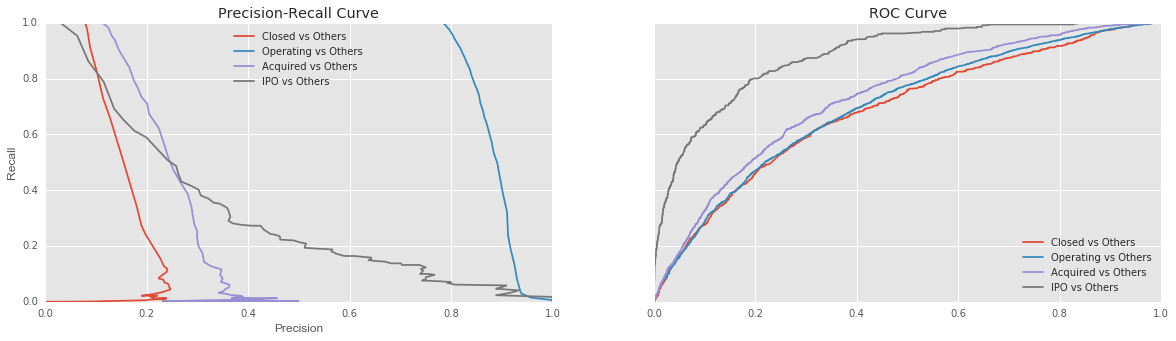

In [441]:
fig, ax = plt.subplots(1,2, figsize=(20,5), sharey=True)
fig.subplots_adjust(hspace=.5)
for i, model in enumerate(all_PossibleModels):
    ax[0].plot(model['pr_curve'][0], model['pr_curve'][1], label=model['name'])
    ax[0].set_title('Precision-Recall Curve')
    ax[0].set_xlabel('Precision')
    ax[0].set_ylabel('Recall')
    ax[0].set_label(model['name'])
    ax[0].legend(title='', loc='best')
    
    ax[1].plot(model['roc'][0], model['roc'][1],label=model['name'])
    ax[1].set_title('ROC Curve')
    ax[1].legend(title='', loc='best')
  
plt.show()

# Getting Predictive Probabilities Multi Class XGBoost

In [443]:

includeDummy = True
includeGlassdoor = True
reg_df = getDataForMultiClassification(cbUSA_dfWithVC,cbUSA_dfWDummy,distinct_glassdoorDf,
                                   median_scoreDict,includeDummy,includeGlassdoor)

X = reg_df.drop('statusID',1)
y = reg_df['statusID']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [444]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)


pred_prob_xgb = model_xgb.predict_proba(X_test)


/Users/deepakgautam/anaconda/lib/python3.5/site-packages/xgboost/core.py:840: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  preds = preds.reshape(nrow, preds.size / nrow)


In [445]:
pred_prob_xgb

array([[ 0.08347249,  0.86420786,  0.04889429,  0.0034254 ],
       [ 0.08956181,  0.75662577,  0.13697381,  0.01683861],
       [ 0.08374008,  0.89451367,  0.01973316,  0.00201305],
       ..., 
       [ 0.08374386,  0.8469193 ,  0.06107091,  0.00826588],
       [ 0.08290484,  0.88559163,  0.02951061,  0.00199297],
       [ 0.05949424,  0.80196297,  0.12623863,  0.01230419]], dtype=float32)

In [461]:
# We can pickle this model to get predictive analysis in the page